In [23]:
import sys
sys.path.append('..')
from dataloader.datamodule_ecog2ph import ECoGPhonemeDataset, ECoGPhonemeDataModule
import numpy as np
import torch
from utils.utils import load_cfg_and_ckpt_path,load_model
from model.phoneme_ctc import SpeechModel
import time
import tqdm
import torchaudio
from pathlib import Path
import re
import string
regex = re.compile('[%s]' % re.escape(string.punctuation))


In [50]:
import torchaudio
import matplotlib.pyplot as plt

In [116]:
model,cfg = load_model('../outputs/2023-10-02/08-13-46/phoneme_ctc_tm1k',
                       MODEL=SpeechModel, mode='latest')

model = model.net.eval().to(device)

In [117]:

cfg,_ = load_cfg_and_ckpt_path('../outputs/2023-10-02/08-13-46/phoneme_ctc_tm1k')

datamodule = ECoGPhonemeDataModule(**cfg['data'])





In [118]:
test_dataloader = datamodule.test_dataloader()

In [119]:
test_dataloader.dataset.transform=None

In [120]:
#cfg, ckpt_path = load_cfg_and_ckpt_path(output_path, mode='latest',verbose=False)
#model = SpeechModel(**cfg['model'])

In [121]:
ecog_files =[f for f,_ in datamodule._load_data('test')]

texts = [t for _,t in datamodule._load_data('test')]

In [122]:
device='cuda'

In [180]:
#ecog_file

preds=[]
spans=[]
for ecog_file in ecog_files:
    ecog = np.load(ecog_file)
    ecog = ECoGPhonemeDataset._preprocess(ecog)
    ecog_len = torch.tensor([len(ecog)])
    ecog = torch.tensor(ecog).unsqueeze(0).to(device).float()


    with torch.no_grad():
        logits, _, logit_lens = model.transcriber(ecog, ecog_len)

    phpos=logits[:,0].cpu().softmax(-1).numpy()
    non_blank = np.nonzero((phpos[:,:2].sum(-1)<0.5)*1.0)[0]
    start, end = non_blank[0],non_blank[-1]
    spans.append([start,end])
    x = logits[:,0].clone().cpu().to(torch.float32)[None,...]
    pred = np.array([t.item() for t in model.test_search(x)[0][0].tokens if t not in [0,1]])
    preds.append(pred)#phpos.argmax(-1))

In [126]:
def text2phs(text):
    words = text.split(' ')
    phs = []
    for word in words:
        try:
            phs += test_dataloader.dataset.word2phs[word]
        except:
            print(words)
    return phs

In [127]:
gtphs = [np.array([ph for ph in text2phs(text) if ph != '|']) for text in texts]

In [181]:
pers = []

for predph, gtph in zip(phs, gtphs):
    pers.append(torchaudio.functional.edit_distance(predph,gtph)/len(gtph))
    

In [182]:
errors=[]
for ecog_file,(s,e) in zip(ecog_files,spans):
    tag_num = ecog_file.stem.split('_')[-1]
    state = np.load(f'/data/cheoljun/b3_features/hubert-ecog-it15_l4/tm1k/{tag_num}.npy')
    simmat=(state@state.T)
    simmat=  simmat[s*3:e*3,s*3:e*3]
    error=((abs(np.arange(len(simmat))[None,:]-np.arange(len(simmat))[:,None]))*abs(simmat)).mean()
    errors.append(error)

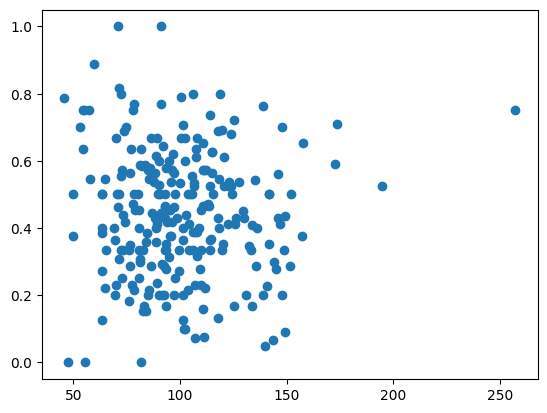

In [183]:
plt.scatter(errors,pers)

In [91]:
tag_num = ecog_file.stem.split('_')[-1]

'9887'

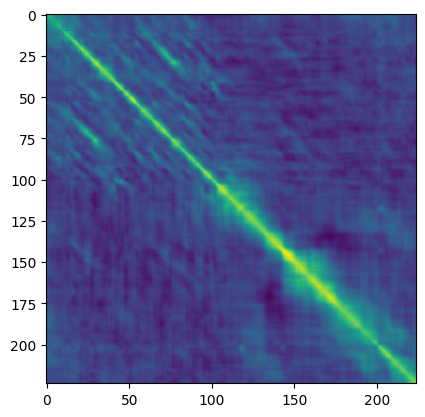

In [184]:
plt.imshow(state@state.T)

In [87]:
simmat=(state@state.T)

In [88]:
abs(simmat)

array([[20.645235  , 19.878973  , 16.351974  , ...,  0.1768538 ,
         0.12646571,  0.33867595],
       [19.878973  , 20.427181  , 16.601843  , ...,  0.5254685 ,
         0.2816971 ,  0.3358181 ],
       [16.351974  , 16.601843  , 18.692316  , ...,  1.4534894 ,
         1.0662674 ,  1.0416698 ],
       ...,
       [ 0.1768538 ,  0.5254685 ,  1.4534894 , ..., 39.227608  ,
        38.033188  , 35.041245  ],
       [ 0.12646571,  0.2816971 ,  1.0662674 , ..., 38.033188  ,
        38.535374  , 36.857     ],
       [ 0.33867595,  0.3358181 ,  1.0416698 , ..., 35.041245  ,
        36.857     , 38.36594   ]], dtype=float32)

In [89]:
((abs(np.arange(len(simmat))[None,:]-np.arange(len(simmat))[:,None]))*abs(simmat)).mean()

146.80513201684963

(array([ 2840., 19526., 14984.,  6276.,  3162.,  1629.,   817.,   514.,
          336.,    92.]),
 array([-7.62397003, -2.90272832,  1.81851351,  6.53975534, 11.26099682,
        15.98223877, 20.70347977, 25.42472267, 30.14596367, 34.86720657,
        39.58844757]),
 <BarContainer object of 10 artists>)

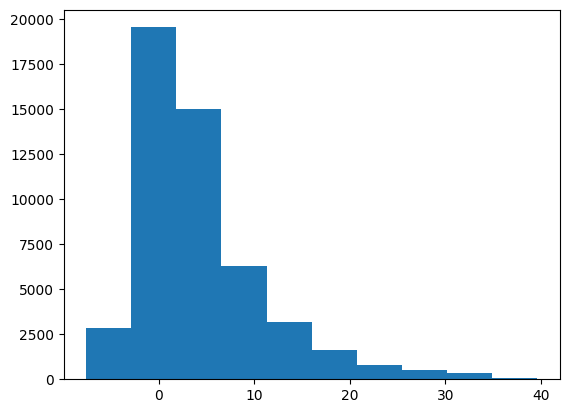

In [72]:
plt.hist((state@state.T).ravel())

In [66]:
import matplotlib.pyplot as plt

In [38]:
test_dataloader.dataset.word2phs

{'i': ['AY', '|'],
 'feel': ['F', 'IY', 'L', '|'],
 'like': ['L', 'AY', 'K', '|'],
 'driving': ['D', 'R', 'AY', 'V', 'IH', 'NG', '|'],
 'are': ['AA', 'R', '|'],
 'you': ['Y', 'UW', '|'],
 'terrible': ['T', 'EH', 'R', 'AH', 'B', 'AH', 'L', '|'],
 'hungry': ['HH', 'AH', 'NG', 'G', 'R', 'IY', '|'],
 'how': ['HH', 'AW', '|'],
 'about': ['AH', 'B', 'AW', 'T', '|'],
 'in': ['IH', 'N', '|'],
 'the': ['DH', 'AH', '|'],
 'morning': ['M', 'AO', 'R', 'N', 'IH', 'NG', '|'],
 'when': ['W', 'EH', 'N', '|'],
 'did': ['D', 'IH', 'D', '|'],
 'it': ['IH', 'T', '|'],
 'start': ['S', 'T', 'AA', 'R', 'T', '|'],
 'well': ['W', 'EH', 'L', '|'],
 'what': ['W', 'AH', 'T', '|'],
 'they': ['DH', 'EY', '|'],
 'try': ['T', 'R', 'AY', '|'],
 'but': ['B', 'AH', 'T', '|'],
 'its': ['IH', 'T', 'S', '|'],
 'so': ['S', 'OW', '|'],
 'hard': ['HH', 'AA', 'R', 'D', '|'],
 'much': ['M', 'AH', 'CH', '|'],
 'is': ['IH', 'Z', '|'],
 'there': ['DH', 'EH', 'R', '|'],
 'their': ['DH', 'EH', 'R', '|'],
 'wish': ['W', 'IH', 'SH', '

In [ ]:
batch

In [ ]:

args = parser.parse_args()
output_path = args.output_path
cfg, ckpt_path = load_cfg_and_ckpt_path(output_path, mode='latest',verbose=False)
model = SpeechModel(**cfg['model'])
datamodule = ECoGPhonemeDataModule(**cfg['data'])
dataloader = datamodule.test_dataloader()
    trainer = pl.Trainer(accelerator='gpu', devices=[0])
    trainer.test(model, dataloader,ckpt_path=ckpt_path)
    results = model.test_results
    errors = {metric:np.mean(result) for metric,result in results.items()}
         
    with open(output_path+"/test_scores.json", "w") as outfile:
        json.dump(errors, outfile)
    
    print(errors)

  m dataloader.datamodule_ecog2ph import ECoGPhonemeDataset, ECoGPhonemeDataModule
import numpy as np
import torch
from utils.utils import load_cfg_and_ckpt_path
from model.phoneme_ctc import SpeechModel
import time
import tqdm
import torchaudio
from pathlib import Path
import re
import string
regex = re.compile('[%s]' % re.escape(string.punctuation))
